In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Library Import

# Data Import and Discovery

## Data Loader

In this section, an MNistDataLoader() class is defined with some basic functions to read the binary data from the dataset and load them as lists of data instances.

In [2]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
import kagglehub


# Download latest version
dataset_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", dataset_path)


# MNIST Data Loader Class

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    # Function to read the labels and load
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)      

c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\mnguyen6\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


## Data Visualization

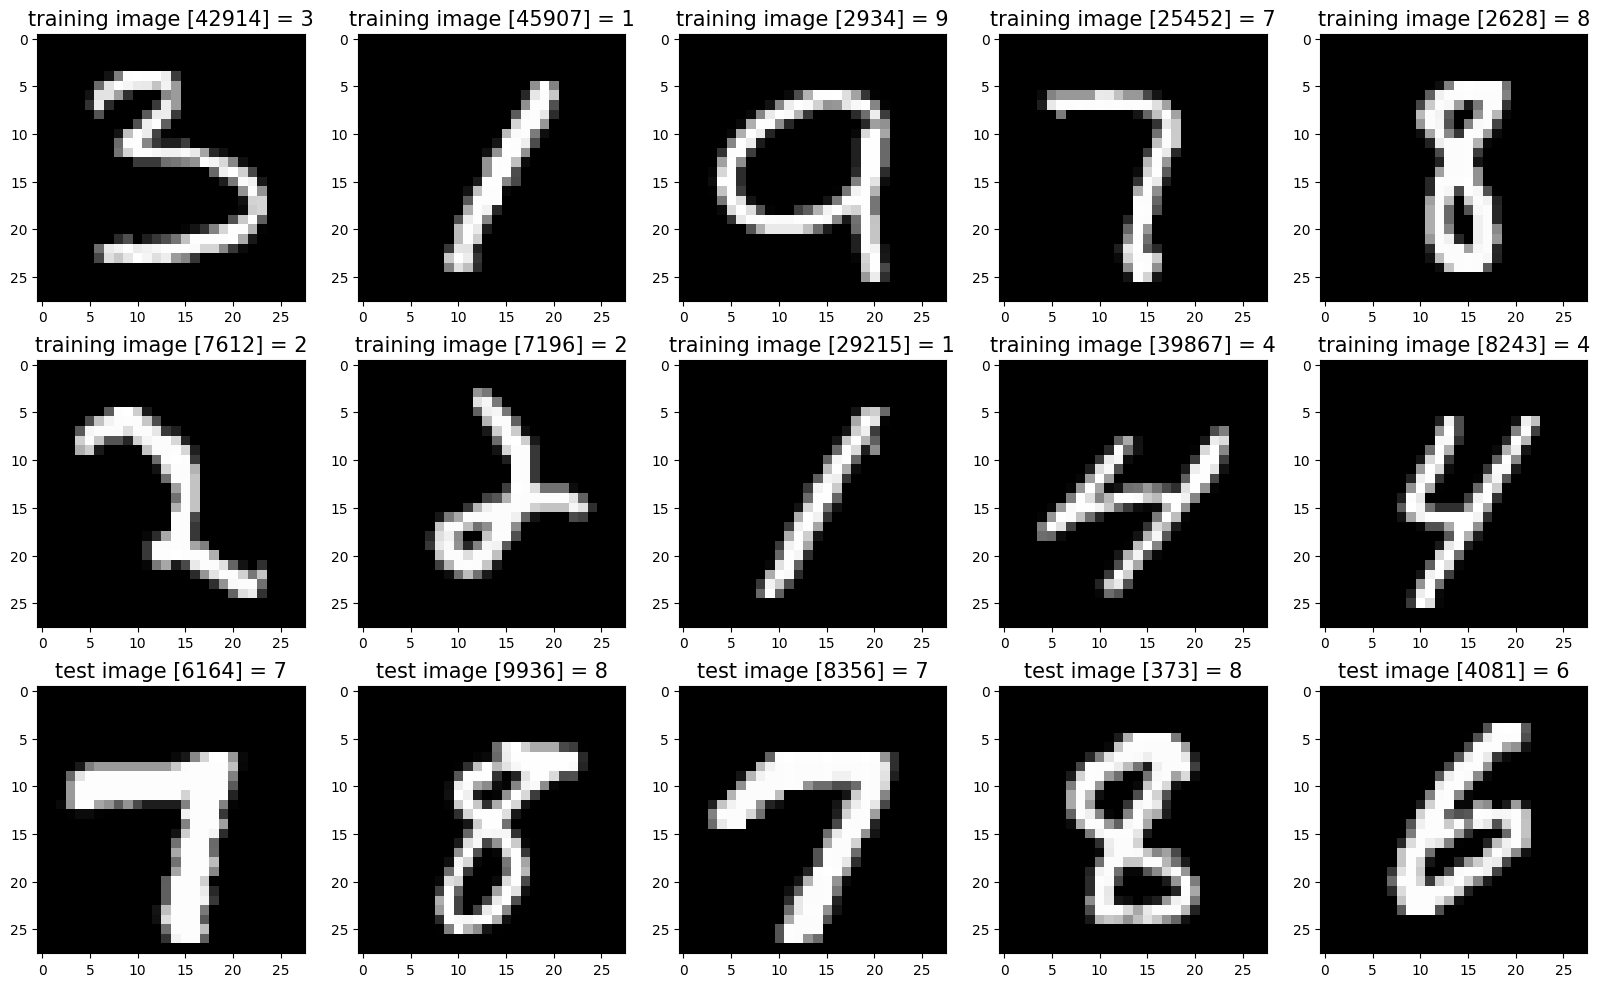

In [3]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

# Set file paths based on added MNIST Datasets
base_path = 'data'
training_images_filepath = join(base_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(base_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(base_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(base_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols)
    plt.figure(figsize=(cols*4,rows*4))
    
    for index, x in enumerate(zip(images, title_texts)):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index+1)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        


# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_trainval, y_trainval), (x_test, y_test) = mnist_dataloader.load_data()


# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_trainval[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_trainval[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [4]:
x_trainval_dim = np.shape(x_trainval)
y_trainval_dim = np.shape(y_trainval)

x_test_dim = np.shape(x_test)
y_test_dim = np.shape(y_test)

print(f"There are {x_trainval_dim[0]} samples in the training dataset, each of size {x_trainval_dim[1],x_trainval_dim[2]} \n"
      f"There are {x_test_dim[0]} samples in the testing dataset ")

print(f"The training label set has dimension of {y_trainval_dim}")

There are 60000 samples in the training dataset, each of size (28, 28) 
There are 10000 samples in the testing dataset 
The training label set has dimension of (60000,)


In [5]:
np.shape(x_trainval[1])

(28, 28)

## Train-Validation Data Split

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_trainval,
                                                  y_trainval,
                                                  test_size=0.2,
                                                  random_state=12)

x_train_dim = np.shape(x_train)
y_train_dim = np.shape(y_train)

x_val_dim = np.shape(x_val)
y_val_dim = np.shape(y_val)

print("After the train-validation data split")

print(f"There are {x_train_dim[0]} samples in the training dataset, each of size {x_train_dim[1:]}. \n"
      f"There are {x_val_dim[0]} samples in the validation dataset.\n"
      f"There are {x_test_dim[0]} samples in the testing dataset.")

print(f"The training label set has dimension of {y_train_dim}")

# The input shape to the NN is the number of pixels in an MNIST image (28x28=784 input)
INPUT_SHAPE = x_train_dim[1:]

After the train-validation data split
There are 48000 samples in the training dataset, each of size (28, 28). 
There are 12000 samples in the validation dataset.
There are 10000 samples in the testing dataset.
The training label set has dimension of (48000,)


## Data Generator

I found that when training or evaluating a model on a GPU with limited RAM (such as 8GB RAM cards like the T1000 or RTX4060), the code often fails since TensorFlow tries to load the full arrays into the GPU memory (even when loading in batches). This code block is an attempt to solve this problem by using a generator to generate data from the training sets to the model in batches. These generators are used directly in model training and testing

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


BATCH_SIZE = 32

# These generator objects will generate BATCH_SIZE samples at a time from the specified nparray
train_gen = DataGenerator(x_train,y_train,BATCH_SIZE)
val_gen = DataGenerator(x_val,y_val,BATCH_SIZE)
test_gen = DataGenerator(x_test,y_test,BATCH_SIZE)

In [14]:
for i, (batch_x, batch_y) in enumerate(train_gen):
    print(f"Batch {i+1}:")
    print("  Shape of batch_x:", np.shape(batch_x))
    print("  Shape of batch_y:", np.shape(batch_y))

Batch 1:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 2:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 3:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 4:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 5:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 6:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 7:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 8:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 9:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 10:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 11:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 12:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 13:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 14:
  Shape of batch_x: (32, 28, 28)
  Shape of batch_y: (32,)
Batch 15:
  Shape of batch_x: (32, 28, 28)


# Deep Fully-Connected ANN

## ANN Model Construction Function

In [ ]:
import tensorflow as tf                                 # General machine learning functionalities                    
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

def build_ann_model(layer_widths, input_shape, activation, loss, metrics, learning_rate):
    """
    Creates a Keras Sequential model based on the specified architecture.

    Args:
        layer_widths (list): A list where each element is the number of nodes in a layer.
        input_shape (tuple): Shape of the input data (e.g., (num_features,)).
        activation (str): Activation function to use in the hidden layers.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model (Sequential): A compiled Keras Sequential model.
    """
    model = keras.Sequential()

    if activation == None: activation = 'relu'
    # Add additional hidden layers based on layer_widths
    model.add(layers.Flatten(input_shape=input_shape)
    for i,width in enumerate(layer_widths):
        if i==0: 
            model.add(layers.Dense(width, activation=activation))
        else: 
            model.add(layers.Dense(width, activation=activation))
        model.add(layers.BatchNormalization())

    # Add the output layer (no activation for regression)
    model.add(layers.Dense(1,name = "Output_layer"))

    # Compile the model with a regression-friendly loss function
    if loss == None: loss = 'binary_crossentropy'
    if metrics == None: metrics = ['accuracy','precision',]
    if learning_rate == None: learning_rate == 0.0001

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss=loss, 
                  metrics=metrics)
    
    return model

In [21]:
LAYER_WIDTHS = [64,32,16,1]
LEARNING_RATE = 0.0001
EPOCH = 100
tf.keras.backend.clear_session()
model = build_ann_model(layer_widths = LAYER_WIDTHS,
                        input_shape= INPUT_SHAPE,
                        activation='relu',
                        loss='binary_crossentropy',
                        metrics=['accuracy','precision'],
                        learning_rate=LEARNING_RATE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 16)                5

## Model Experimentation Training

In [22]:
history = model.fit(train_gen,
                    batch_size=BATCH_SIZE,
                    validation_data=val_gen,
                    epochs = EPOCH)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mnguyen6\AppData\Local\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential" expects 1 input(s), but it received 896 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:16' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:17' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:18' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:19' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:20' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:21' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:22' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:23' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:24' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:25' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:26' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:27' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:28' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:29' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:30' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:31' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:32' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:33' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:34' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:35' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:36' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:37' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:38' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:39' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:40' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:41' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:42' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:43' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:44' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:45' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:46' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:47' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:48' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:49' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:50' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:51' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:52' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:53' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:54' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:55' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:56' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:57' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:58' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:59' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:60' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:61' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:62' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:63' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:64' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:65' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:66' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:67' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:68' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:69' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:70' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:71' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:72' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:73' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:74' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:75' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:76' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:77' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:78' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:79' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:80' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:81' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:82' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:83' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:84' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:85' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:86' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:87' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:88' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:89' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:90' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:91' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:92' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:93' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:94' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:95' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:96' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:97' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:98' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:99' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:100' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:101' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:102' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:103' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:104' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:105' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:106' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:107' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:108' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:109' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:110' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:111' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:112' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:113' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:114' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:115' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:116' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:117' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:118' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:119' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:120' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:121' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:122' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:123' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:124' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:125' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:126' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:127' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:128' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:129' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:130' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:131' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:132' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:133' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:134' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:135' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:136' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:137' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:138' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:139' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:140' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:141' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:142' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:143' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:144' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:145' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:146' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:147' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:148' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:149' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:150' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:151' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:152' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:153' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:154' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:155' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:156' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:157' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:158' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:159' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:160' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:161' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:162' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:163' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:164' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:165' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:166' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:167' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:168' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:169' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:170' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:171' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:172' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:173' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:174' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:175' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:176' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:177' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:178' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:179' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:180' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:181' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:182' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:183' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:184' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:185' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:186' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:187' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:188' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:189' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:190' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:191' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:192' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:193' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:194' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:195' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:196' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:197' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:198' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:199' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:200' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:201' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:202' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:203' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:204' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:205' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:206' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:207' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:208' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:209' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:210' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:211' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:212' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:213' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:214' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:215' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:216' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:217' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:218' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:219' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:220' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:221' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:222' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:223' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:224' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:225' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:226' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:227' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:228' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:229' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:230' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:231' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:232' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:233' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:234' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:235' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:236' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:237' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:238' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:239' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:240' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:241' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:242' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:243' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:244' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:245' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:246' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:247' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:248' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:249' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:250' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:251' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:252' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:253' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:254' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:255' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:256' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:257' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:258' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:259' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:260' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:261' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:262' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:263' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:264' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:265' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:266' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:267' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:268' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:269' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:270' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:271' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:272' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:273' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:274' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:275' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:276' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:277' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:278' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:279' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:280' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:281' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:282' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:283' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:284' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:285' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:286' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:287' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:288' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:289' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:290' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:291' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:292' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:293' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:294' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:295' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:296' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:297' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:298' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:299' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:300' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:301' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:302' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:303' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:304' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:305' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:306' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:307' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:308' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:309' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:310' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:311' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:312' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:313' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:314' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:315' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:316' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:317' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:318' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:319' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:320' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:321' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:322' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:323' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:324' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:325' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:326' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:327' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:328' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:329' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:330' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:331' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:332' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:333' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:334' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:335' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:336' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:337' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:338' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:339' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:340' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:341' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:342' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:343' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:344' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:345' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:346' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:347' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:348' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:349' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:350' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:351' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:352' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:353' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:354' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:355' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:356' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:357' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:358' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:359' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:360' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:361' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:362' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:363' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:364' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:365' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:366' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:367' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:368' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:369' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:370' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:371' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:372' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:373' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:374' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:375' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:376' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:377' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:378' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:379' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:380' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:381' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:382' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:383' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:384' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:385' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:386' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:387' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:388' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:389' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:390' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:391' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:392' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:393' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:394' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:395' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:396' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:397' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:398' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:399' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:400' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:401' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:402' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:403' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:404' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:405' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:406' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:407' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:408' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:409' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:410' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:411' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:412' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:413' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:414' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:415' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:416' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:417' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:418' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:419' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:420' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:421' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:422' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:423' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:424' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:425' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:426' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:427' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:428' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:429' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:430' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:431' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:432' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:433' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:434' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:435' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:436' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:437' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:438' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:439' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:440' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:441' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:442' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:443' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:444' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:445' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:446' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:447' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:448' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:449' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:450' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:451' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:452' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:453' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:454' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:455' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:456' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:457' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:458' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:459' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:460' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:461' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:462' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:463' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:464' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:465' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:466' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:467' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:468' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:469' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:470' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:471' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:472' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:473' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:474' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:475' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:476' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:477' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:478' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:479' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:480' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:481' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:482' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:483' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:484' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:485' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:486' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:487' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:488' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:489' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:490' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:491' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:492' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:493' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:494' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:495' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:496' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:497' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:498' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:499' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:500' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:501' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:502' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:503' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:504' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:505' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:506' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:507' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:508' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:509' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:510' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:511' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:512' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:513' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:514' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:515' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:516' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:517' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:518' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:519' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:520' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:521' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:522' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:523' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:524' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:525' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:526' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:527' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:528' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:529' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:530' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:531' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:532' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:533' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:534' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:535' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:536' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:537' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:538' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:539' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:540' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:541' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:542' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:543' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:544' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:545' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:546' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:547' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:548' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:549' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:550' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:551' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:552' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:553' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:554' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:555' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:556' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:557' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:558' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:559' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:560' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:561' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:562' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:563' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:564' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:565' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:566' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:567' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:568' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:569' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:570' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:571' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:572' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:573' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:574' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:575' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:576' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:577' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:578' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:579' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:580' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:581' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:582' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:583' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:584' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:585' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:586' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:587' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:588' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:589' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:590' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:591' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:592' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:593' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:594' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:595' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:596' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:597' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:598' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:599' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:600' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:601' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:602' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:603' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:604' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:605' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:606' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:607' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:608' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:609' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:610' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:611' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:612' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:613' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:614' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:615' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:616' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:617' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:618' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:619' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:620' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:621' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:622' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:623' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:624' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:625' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:626' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:627' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:628' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:629' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:630' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:631' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:632' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:633' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:634' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:635' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:636' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:637' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:638' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:639' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:640' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:641' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:642' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:643' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:644' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:645' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:646' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:647' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:648' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:649' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:650' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:651' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:652' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:653' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:654' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:655' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:656' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:657' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:658' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:659' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:660' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:661' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:662' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:663' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:664' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:665' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:666' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:667' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:668' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:669' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:670' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:671' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:672' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:673' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:674' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:675' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:676' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:677' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:678' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:679' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:680' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:681' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:682' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:683' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:684' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:685' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:686' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:687' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:688' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:689' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:690' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:691' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:692' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:693' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:694' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:695' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:696' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:697' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:698' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:699' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:700' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:701' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:702' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:703' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:704' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:705' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:706' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:707' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:708' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:709' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:710' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:711' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:712' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:713' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:714' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:715' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:716' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:717' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:718' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:719' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:720' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:721' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:722' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:723' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:724' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:725' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:726' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:727' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:728' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:729' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:730' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:731' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:732' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:733' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:734' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:735' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:736' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:737' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:738' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:739' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:740' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:741' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:742' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:743' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:744' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:745' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:746' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:747' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:748' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:749' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:750' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:751' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:752' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:753' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:754' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:755' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:756' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:757' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:758' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:759' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:760' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:761' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:762' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:763' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:764' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:765' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:766' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:767' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:768' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:769' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:770' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:771' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:772' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:773' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:774' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:775' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:776' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:777' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:778' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:779' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:780' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:781' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:782' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:783' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:784' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:785' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:786' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:787' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:788' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:789' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:790' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:791' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:792' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:793' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:794' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:795' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:796' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:797' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:798' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:799' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:800' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:801' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:802' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:803' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:804' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:805' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:806' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:807' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:808' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:809' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:810' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:811' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:812' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:813' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:814' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:815' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:816' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:817' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:818' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:819' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:820' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:821' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:822' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:823' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:824' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:825' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:826' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:827' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:828' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:829' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:830' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:831' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:832' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:833' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:834' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:835' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:836' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:837' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:838' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:839' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:840' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:841' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:842' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:843' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:844' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:845' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:846' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:847' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:848' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:849' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:850' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:851' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:852' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:853' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:854' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:855' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:856' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:857' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:858' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:859' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:860' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:861' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:862' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:863' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:864' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:865' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:866' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:867' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:868' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:869' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:870' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:871' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:872' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:873' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:874' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:875' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:876' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:877' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:878' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:879' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:880' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:881' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:882' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:883' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:884' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:885' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:886' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:887' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:888' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:889' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:890' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:891' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:892' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:893' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:894' shape=(None,) dtype=uint8>, <tf.Tensor 'IteratorGetNext:895' shape=(None,) dtype=uint8>]


## Model Prediction and Evaluation

# Convolutional Neural Networks

## CNN Model Construction Function